In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    if i >= iter_max:
        raise Error("No convergence")
    return a

def consumption(c,we,rest,gamma,v,phi):
    return c - we*(we/(phi*c**gamma))**(1/v) - rest

def household_guess(a_grid,e_grid,r,w,gamma,T):
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis] + T[:,np.newaxis]
    V_prime = (1+r)*(wel*0.1)**(-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init=household_guess)
def household(V_prime_p,a_grid,e_grid,r,w,T,beta,gamma,v,phi):

    we = w*e_grid

    c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
    n_prime = (we[:,np.newaxis]/(phi*c_prime**gamma))**(1/v)

    new_grid = (c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis]*n_prime - T[:,np.newaxis])
    wel = (1+r)*a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + we[:,np.newaxis]*n + T[:,np.newaxis] - c
    V_prime= (1+r)*c**(-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size)) + 1E-5
        rest = -a_grid[0] + wel[indexes_asset[1]] + T[indexes_asset[0]]
        bb = c[indexes_asset] + 0.5
        
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)
        n[indexes_asset] = (we[indexes_asset[0]]/(phi*c[indexes_asset]**gamma))**(1/v)
        V_prime[indexes_asset] = (1+r)*(c[indexes_asset])**(-gamma)

    return V_prime,a,c,n

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Tax, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

household_inp= household.add_hetinputs([make_grid,transfers])

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = household_inp.add_hetoutputs([labor_supply])

@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B):
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

blocks_ss = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

calibration = {'gamma': 1, 'v': 1, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 10,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 5.6}

unknowns_ss = {'beta': 0.986, 'phi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'v', 'phi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B']


In [2]:
print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  5.51e-14
Labor market clearing: -5.92e-14
Goods market clearing (untargeted): -3.69e-09


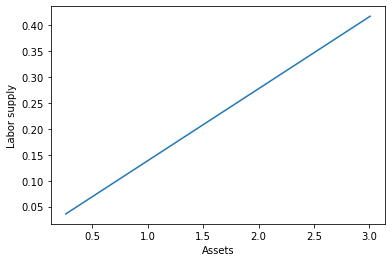

In [5]:
plt.plot(ss0.internals['household']['e_grid'], ss0.internals['household']['T'].T)
plt.xlabel('Labor Shock'), plt.ylabel('Transfer')
plt.show()

In [9]:
def transfers_flat(pi_e, Div, Tax, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

household_inp_flat= household.add_hetinputs([make_grid,transfers_flat])

hh_ext_flat = household_inp_flat.add_hetoutputs([labor_supply])

blocks_ss_flat = [hh_ext_flat, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss_flat = create_model(blocks_ss_flat, name="One-Asset HANK SS")

In [10]:
ss0_flat = hank_ss_flat.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  5.51e-14
Labor market clearing: -5.92e-14
Goods market clearing (untargeted): -3.69e-09


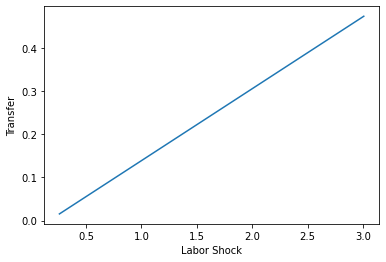

In [17]:
plt.plot(ss0_flat.internals['household']['e_grid'], ss0_flat.internals['household']['T'].T)
plt.xlabel('Labor Shock'), plt.ylabel('Transfer')
plt.show()

In [25]:
def transfers_prog(pi_e, Div, Tax, e_grid,w,q):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    richest = e_grid.size-1
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    tax[0] = tax[0] - w*e_grid[0]*q
    tax[richest] = tax[richest] + w*e_grid[0]*q*pi_e[0]/pi_e[richest]
    T = div - tax
    return T

e_grid, Pi, a_grid, pi_e = make_grid(0.9,1,10,0,100,200)

In [27]:
pi_e@transfers_prog(pi_e,0.167,0.028,e_grid,0.834,0.5)

0.139

In [28]:
household_inp_prog = household.add_hetinputs([make_grid,transfers_prog])

hh_ext_prog = household_inp_prog.add_hetoutputs([labor_supply])

blocks_ss_prog = [hh_ext_prog, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss_prog = create_model(blocks_ss_prog, name="One-Asset HANK SS")

In [39]:
calibration = {'gamma': 1, 'v': 1, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 5.6, 'q': 0.5}

unknowns_ss = {'beta': 0.986, 'phi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0_prog = hank_ss_prog.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  5.51e-14
Labor market clearing: -5.92e-14
Goods market clearing (untargeted): -3.69e-09


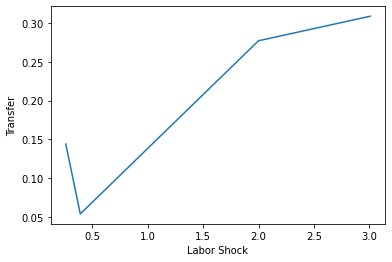

In [40]:
plt.plot(ss0_prog.internals['household']['e_grid'], ss0_prog.internals['household']['T'].T)
plt.xlabel('Labor Shock'), plt.ylabel('Transfer')
plt.show()

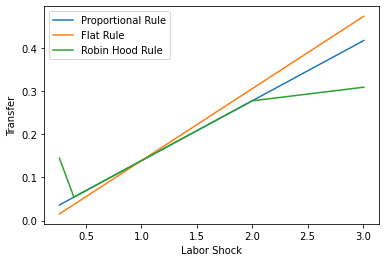

In [41]:
plt.plot(ss0.internals['household']['e_grid'], ss0.internals['household']['T'].T, label = "Proportional Rule")
plt.plot(ss0_flat.internals['household']['e_grid'], ss0_flat.internals['household']['T'].T, label = "Flat Rule")
plt.plot(ss0_prog.internals['household']['e_grid'], ss0_prog.internals['household']['T'].T, label = "Robin Hood Rule")
plt.xlabel('Labor Shock'), plt.ylabel('Transfer')
plt.legend()
plt.show()

In [42]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res


blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

blocks_flat = [hh_ext_flat, firm, monetary, fiscal, mkt_clearing, nkpc]
hank_flat = create_model(blocks_flat, name="One-Asset HANK")

ss = hank.steady_state(ss0)
ss_flat = hank_flat.steady_state(ss0_flat)

In [ ]:
blocks_prog = [hh_ext_prog, firm, monetary, fiscal, mkt_clearing, nkpc]
hank_prog = create_model(blocks_prog, name="One-Asset HANK")

ss_prog = hank_prog.steady_state(ss0_prog)

In [43]:
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
G_flat = hank_flat.solve_jacobian(ss_flat, unknowns, targets, exogenous, T=T)

In [ ]:
G_prog = hank_prog.solve_jacobian(ss_prog, unknowns, targets, exogenous, T=T)

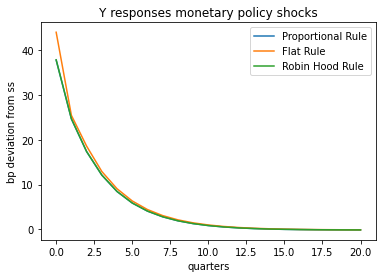

In [44]:
rhos = np.array([0.7])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['Y']['rstar'] @ drstar
dpi_flat = G_flat['Y']['rstar'] @ drstar
dpi_prog = G_prog['Y']['rstar'] @ drstar

plt.plot(10000 * dpi[:21], label = "Proportional Rule")
plt.plot(10000 * dpi_flat[:21], label = "Flat Rule")
plt.plot(10000 * dpi_prog[:21], label = "Robin Hood Rule")
plt.title(r'Y responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.legend()
plt.show()

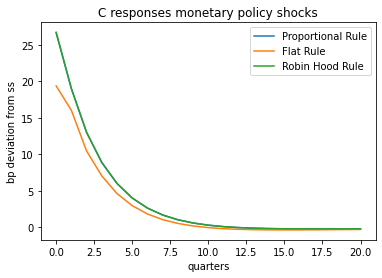

In [49]:
dpi = G['N']['rstar'] @ drstar
dpi_flat = G_flat['N']['rstar'] @ drstar
dpi_prog = G_prog['N']['rstar'] @ drstar

plt.plot(10000 * dpi[:21], label = "Proportional Rule")
plt.plot(10000 * dpi_flat[:21], label = "Flat Rule")
plt.plot(10000 * dpi_prog[:21], label = "Robin Hood Rule")
plt.title(r'C responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.legend()
plt.show()

<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'Tax', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Z']>